### In case no images load, change mode to 'Trusted' in upper-right corner.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from time import time
import scipy
import sklearn
import re

from ensembles import RandomForestMSE
from ensembles import GradientBoostingMSE
%config InlineBackend.figure_format = 'svg' 

# Стандартный шрифт sns - 12, а хотим 14
sns.set(style="whitegrid", font_scale=14/12)

In [2]:
data = pd.read_csv(r'.\kc_house_data.csv')

target = data.price

data = data.drop(columns=['id', 'price'])

data.tail(5)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21608,20140521T000000,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,20150223T000000,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,20150116T000000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,20141015T000000,2,0.75,1020,1076,2.0,0,0,3,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [3]:
year, month, day = data.date.str[:4].astype(int), data.date.str[4:6].astype(int), data.date.str[6:8].astype(int)
day

0        13
1         9
2        25
3         9
4        18
         ..
21608    21
21609    23
21610    23
21611    16
21612    15
Name: date, Length: 21613, dtype: int32

In [4]:
from sklearn.preprocessing import OrdinalEncoder
#data.date = OrdinalEncoder().fit_transform(data.date.to_numpy().reshape(-1, 1))
data = data.drop(columns = 'date')
data['year'] = year
data['month'] = month
data['day'] = day


In [5]:
data.tail(5)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
21608,3,2.50,1530,1131,3.0,0,0,3,8,1530,...,2009,0,98103,47.6993,-122.346,1530,1509,2014,5,21
21609,4,2.50,2310,5813,2.0,0,0,3,8,2310,...,2014,0,98146,47.5107,-122.362,1830,7200,2015,2,23
21610,2,0.75,1020,1350,2.0,0,0,3,7,1020,...,2009,0,98144,47.5944,-122.299,1020,2007,2014,6,23
21611,3,2.50,1600,2388,2.0,0,0,3,8,1600,...,2004,0,98027,47.5345,-122.069,1410,1287,2015,1,16
21612,2,0.75,1020,1076,2.0,0,0,3,7,1020,...,2008,0,98144,47.5941,-122.299,1020,1357,2014,10,15


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=127)

In [7]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [18]:
def RMSE (y_true, prediction):
    return np.mean((y_true - prediction)**2)**(1 / 2)

## Часть 2 

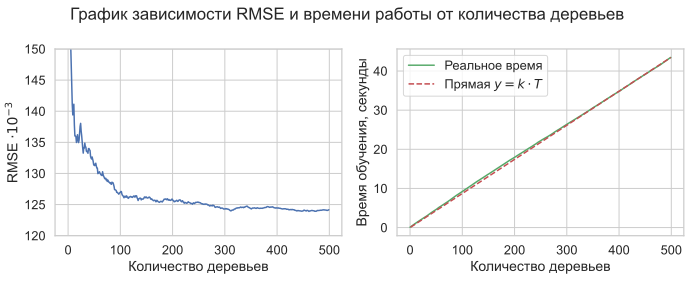

In [19]:
n_estimators = 500
max_depth = None
RMSE_valid = []
feature_subsample_size = 0.6

regressor = RandomForestMSE(n_estimators, max_depth , feature_subsample_size)
history = regressor.fit(X_train, y_train, X_test, y_test)
RMSE_score = history['MSE'] ** 0.5 / 1_000
time = np.cumsum(history['time'])



figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
plt.suptitle('График зависимости RMSE и времени работы от количества деревьев')

plt.subplot(1,2,1)
plt.plot(np.arange(n_estimators), RMSE_score)
plt.xlabel('Количество деревьев', )
plt.ylabel(r'RMSE $\cdot 10^{-3}$')
plt.ylim(120, 150)

figure.tight_layout(pad=1, w_pad=2, h_pad=0)

plt.subplot(1,2,2)
line1, = plt.plot(np.arange(n_estimators), time, color='g')
line2, = plt.plot([1, n_estimators-1], [np.min(time), np.max(time)], color='r', linestyle='--')
plt.xlabel('Количество деревьев', )
plt.ylabel(r'Время обучения, секунды')
plt.legend((line1, line2), ('Реальное время', 'Прямая $y=k \cdot T$'))
plt.savefig(r'.\images\Experiment_2_estimators.pdf', bbox_inches = 'tight')
plt.show()

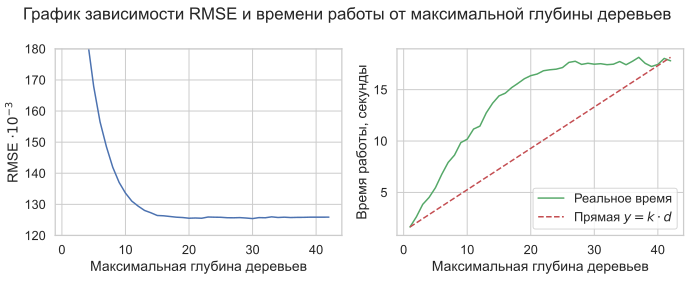

In [20]:
from time import time
n_estimators = 200
max_depth = np.arange(1,43)
feature_subsample_size = 0.6
RMSE_valid = []
time_array = []

for d in max_depth:
    start = time()
    regressor = RandomForestMSE(n_estimators, d, feature_subsample_size)
    regressor.fit(X_train, y_train)
    time_array.append(time() - start)
    RMSE_score = RMSE(y_test, regressor.predict(X_test)) / 1_000
    RMSE_valid.append(RMSE_score)

#time_array = np.cumsum(time_array)

figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
plt.suptitle('График зависимости RMSE и времени работы от максимальной глубины деревьев')

plt.subplot(1,2,1)
plt.plot(max_depth, RMSE_valid)
plt.xlabel('Максимальная глубина деревьев', )
plt.ylabel(r'RMSE $\cdot 10^{-3}$')
plt.ylim(120, 180)

figure.tight_layout(pad=1, w_pad=2, h_pad=0)

plt.subplot(1,2,2)
line1, = plt.plot(max_depth, time_array, color='g')
line2, = plt.plot([1, np.max(max_depth)], [np.min(time_array), np.max(time_array)], color='r', linestyle='--')
plt.xlabel('Максимальная глубина деревьев', )
plt.ylabel(r'Время работы, секунды')
plt.legend((line1, line2), ('Реальное время', 'Прямая $y=k \cdot d$'))

plt.savefig(r'.\images\Experiment_2_depth.pdf', bbox_inches = 'tight')
plt.show()

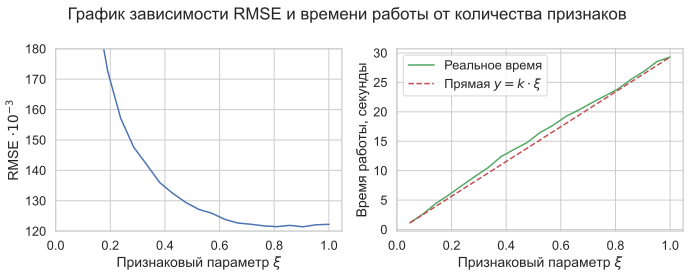

In [21]:
n_estimators = 200
max_depth = None
RMSE_valid = []
time_array = []
feature_subsample_size = np.arange(1, X_train.shape[1]+1) / X_train.shape[1] 

for size in feature_subsample_size:
    start = time()
    regressor = RandomForestMSE(n_estimators , max_depth, size)
    regressor.fit(X_train, y_train)
    time_array.append(time() - start)
    RMSE_score = RMSE(y_test, regressor.predict(X_test)) / 1_000
    RMSE_valid.append(RMSE_score)

#time_array = np.cumsum(time_array)


figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
plt.suptitle('График зависимости RMSE и времени работы от количества признаков')

plt.subplot(1,2,1)
plt.plot(feature_subsample_size, RMSE_valid)
plt.xlabel('Признаковый параметр $\\xi$', )
plt.ylabel(r'RMSE $\cdot 10^{-3}$')
plt.ylim(120, 180)

figure.tight_layout(pad=1, w_pad=2, h_pad=0)

plt.subplot(1,2,2)
line1, = plt.plot(feature_subsample_size, time_array, color='g')
line2, = plt.plot([np.min(feature_subsample_size), np.max(feature_subsample_size)], 
                  [np.min(time_array), np.max(time_array)], color='r', linestyle='--')
plt.xlabel('Признаковый параметр $\\xi$', )
plt.ylabel(r'Время работы, секунды')

plt.legend((line1, line2), ('Реальное время', 'Прямая $y=k \cdot \\xi$'))

plt.savefig(r'.\images\Experiment_2_subspace.pdf', bbox_inches = 'tight')
plt.show()

## Часть 3


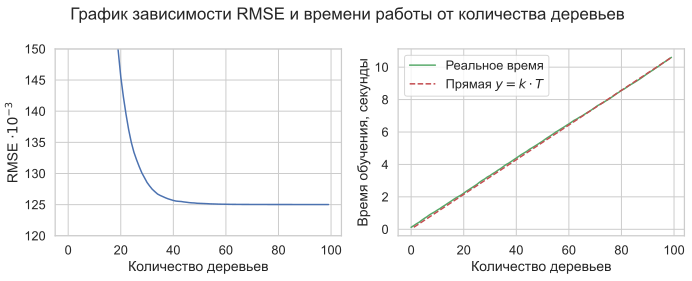

In [22]:
n_estimators = 100
max_depth = None
RMSE_valid = []
feature_subsample_size = 0.6
learning_rate = 0.1

regressor = GradientBoostingMSE(n_estimators, learning_rate, max_depth , feature_subsample_size)
history = regressor.fit(X_train, y_train, X_test, y_test)
RMSE_score = history['MSE'] ** 0.5 / 1_000
time = np.cumsum(history['time'])



figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
plt.suptitle('График зависимости RMSE и времени работы от количества деревьев')

plt.subplot(1,2,1)
plt.plot(np.arange(n_estimators), RMSE_score)
plt.xlabel('Количество деревьев', )
plt.ylabel(r'RMSE $\cdot 10^{-3}$')
plt.ylim(120, 150)

figure.tight_layout(pad=1, w_pad=2, h_pad=0)

plt.subplot(1,2,2)
line1, = plt.plot(np.arange(n_estimators), time, color='g')
line2, = plt.plot([1, n_estimators-1], [np.min(time), np.max(time)], color='r', linestyle='--')
plt.xlabel('Количество деревьев', )
plt.ylabel(r'Время обучения, секунды')
plt.legend((line1, line2), ('Реальное время', 'Прямая $y=k \cdot T$'))
plt.savefig(r'.\images\Experiment_3_estimators.pdf', bbox_inches = 'tight')
plt.show()

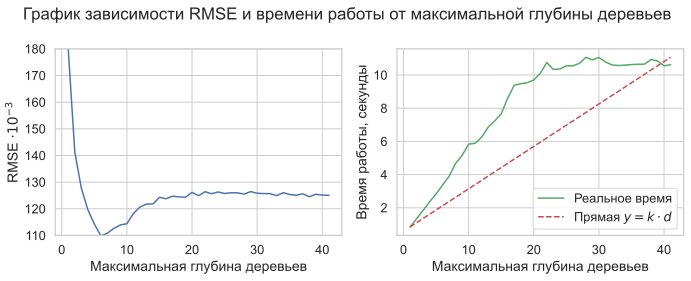

In [23]:
from time import time
n_estimators = 100
max_depth = np.arange(1,42)
feature_subsample_size = 0.6
learning_rate = 0.1
RMSE_valid = []
time_array = []

for d in max_depth:
    start = time()
    regressor = GradientBoostingMSE(n_estimators, learning_rate, d, feature_subsample_size)
    regressor.fit(X_train, y_train)
    time_array.append(time() - start)
    RMSE_score = RMSE(y_test, regressor.predict(X_test)) / 1_000
    RMSE_valid.append(RMSE_score)

# time_array = np.cumsum(time_array)

figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
plt.suptitle('График зависимости RMSE и времени работы от максимальной глубины деревьев')

plt.subplot(1,2,1)
plt.plot(max_depth, RMSE_valid)
plt.xlabel('Максимальная глубина деревьев', )
plt.ylabel(r'RMSE $\cdot 10^{-3}$')
plt.ylim(110, 180)

figure.tight_layout(pad=1, w_pad=2, h_pad=0)

plt.subplot(1,2,2)
line1, = plt.plot(max_depth, time_array, color='g')
line2, = plt.plot([1, np.max(max_depth)], [np.min(time_array), np.max(time_array)], color='r', linestyle='--')
plt.xlabel('Максимальная глубина деревьев', )
plt.ylabel(r'Время работы, секунды')
plt.legend((line1, line2), ('Реальное время', 'Прямая $y=k \cdot d$'))

plt.savefig(r'.\images\Experiment_3_depth.pdf', bbox_inches = 'tight')
plt.show()

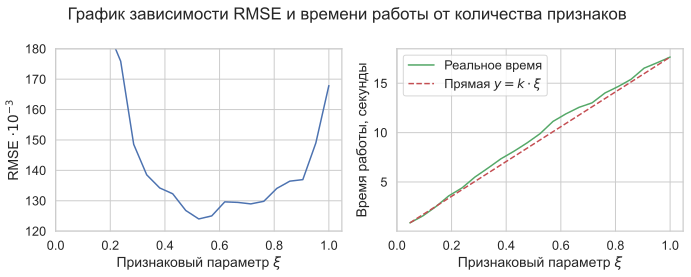

In [24]:
n_estimators = 100
max_depth = None
learning_rate = 0.1
RMSE_valid = []
time_array = []
feature_subsample_size = np.arange(1, X_train.shape[1]+1) / X_train.shape[1] 

for size in feature_subsample_size:
    start = time()
    regressor = GradientBoostingMSE(n_estimators, learning_rate, max_depth , size)
    regressor.fit(X_train, y_train)
    time_array.append(time() - start)
    RMSE_score = RMSE(y_test, regressor.predict(X_test)) / 1_000
    RMSE_valid.append(RMSE_score)

#time_array = np.cumsum(time_array)

figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
plt.suptitle('График зависимости RMSE и времени работы от количества признаков')

plt.subplot(1,2,1)
plt.plot(feature_subsample_size, RMSE_valid)
plt.xlabel('Признаковый параметр $\\xi$', )
plt.ylabel(r'RMSE $\cdot 10^{-3}$')
plt.ylim(120, 180)

figure.tight_layout(pad=1, w_pad=2, h_pad=0)

plt.subplot(1,2,2)
line1, = plt.plot(feature_subsample_size, time_array, color='g')
line2, = plt.plot([np.min(feature_subsample_size), np.max(feature_subsample_size)], 
                  [np.min(time_array), np.max(time_array)], color='r', linestyle='--')
plt.xlabel('Признаковый параметр $\\xi$', )
plt.ylabel(r'Время работы, секунды')

plt.legend((line1, line2), ('Реальное время', 'Прямая $y=k \cdot \\xi$'))

plt.savefig(r'.\images\Experiment_3_subspace.pdf', bbox_inches = 'tight')
plt.show()

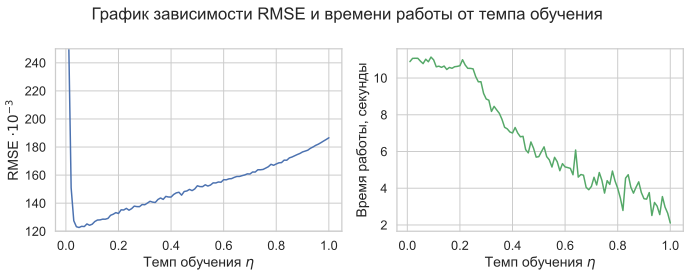

In [26]:
n_estimators = 100
max_depth = None
learning_rate = np.arange(1,101,1)/100
RMSE_valid = []
time_array = []
feature_subsample_size = 0.6

for rate in learning_rate:
    start = time()
    regressor = GradientBoostingMSE(n_estimators, rate, max_depth , feature_subsample_size)
    regressor.fit(X_train, y_train)
    time_array.append(time() - start)
    RMSE_score = RMSE(y_test, regressor.predict(X_test)) / 1_000
    RMSE_valid.append(RMSE_score)

# time_array = np.cumsum(time_array)

figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
plt.suptitle('График зависимости RMSE и времени работы от темпа обучения')

plt.subplot(1,2,1)
plt.plot(learning_rate, RMSE_valid)
plt.xlabel('Темп обучения $\\eta$')
plt.ylabel(r'RMSE $\cdot 10^{-3}$')
plt.ylim(120, 250)

figure.tight_layout(pad=1, w_pad=2, h_pad=0)

plt.subplot(1,2,2)
line1, = plt.plot(learning_rate, time_array, color='g')
#line2, = plt.plot([np.min(learning_rate), np.max(learning_rate)], 
#                  [np.min(time_array), np.max(time_array)], color='r', linestyle='--')
plt.xlabel('Темп обучения $\\eta$')
plt.ylabel(r'Время работы, секунды')

#plt.legend((line1, line2), ('Реальное время', 'Прямая $y=k \cdot \\eta$'))

plt.savefig(r'.\images\Experiment_3_rate.pdf', bbox_inches = 'tight')
plt.show()

In [29]:
# Best RMSE
n_estimators = 100
max_depth = 7
learning_rate = 0.1
feature_subsample_size = 0.5
regressor = GradientBoostingMSE(n_estimators, learning_rate, max_depth , feature_subsample_size)
regressor.fit(X_train, y_train)
RMSE_score = RMSE(y_test, regressor.predict(X_test)) / 1_000
RMSE_score

110.70306519183927